In [0]:
import pandas as pd
import datetime
import numpy as np 
import pandas_datareader.data as web
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix 
from math import ceil 
from sklearn import preprocessing 
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#Added
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Perceptron



High         Low  ...     Volume   Adj Close
Date                                ...                       
2019-08-26  178.399994  176.380005  ...   723500.0  178.350006
2019-08-27  179.699997  177.199997  ...  1096100.0  178.509995
2019-08-28  178.309998  176.279999  ...   554300.0  178.240005
2019-08-29  181.830002  179.520004  ...   560200.0  181.160004
2019-08-30  182.279999  180.029999  ...   690300.0  180.910004

[5 rows x 6 columns]

'3.0.3'

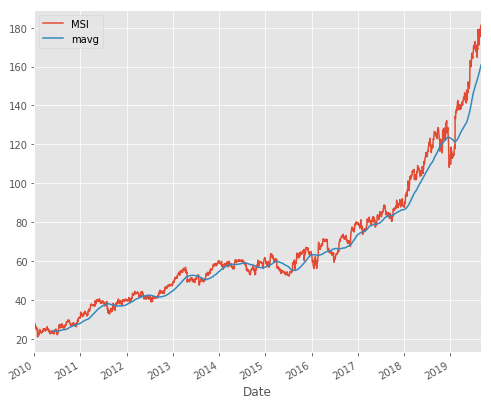

In [0]:
#Loading Yahoo Finance dataset
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2019, 9, 1)

df = web.DataReader("MSI", "yahoo", start, end)
df.tail()

#Find the rolling mean of the stock
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

#to better understand rolling mean, let's plot it on matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style

#adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

#Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='MSI')
mavg.plot(label='mavg')
plt.legend()



In [0]:
#Engineering some features for the algorithms: High Low Percentage and Percentage Change
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

#Drop missing value
dfreg.fillna(value=-99999, inplace = True)
dfreg.dropna(inplace=True) 

#we want to separate 1% of the data to forecast
forecast_out = int(ceil(.01 * len(dfreg))) 





In [0]:
#separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

In [0]:
#Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

#Finally we want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

#Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

##TIME TO START THE CLASSIFIERS!

#CORRECTION: DEFINING X_train before we use it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sys
stdout = sys.stdout
#reload(sys)
#sys.setdefaultencoding('utf-8')
sys.stdout = stdout


#Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

#Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

#Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

#KNN regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)


#Quadratic Regression, BayesianRidge
clfpolyb = make_pipeline(PolynomialFeatures(3), BayesianRidge()).fit(X_train, y_train)


#Perceptron regression
#clfperceptron = Perceptron(fit_intercept=False, max_iter=10, tol=None, shuffle=False).fit(X_train, y_train)



#let's evaluate all of the models against eachother
confidencereg = clfreg.score(X_test,y_test)
confidencepoly2 = clfpoly2.score(X_test, y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

#Added BayesianRidge
confidencepolyb = clfpolyb.score(X_test,y_test)

#Tried to add Perceptron but couldn't get it to work.
#confidenceperceptron = clfperceptron.score(X_test, y_test)

# results
('The linear regression confidence is', confidencereg)
('The quadratic regression 2 confidence is ', confidencepoly2)
('The quadratic regression 3 confidence is ', confidencepoly3)
('The knn regression confidence is ', confidenceknn)
('The quadratic regression bayesian confidence is ', confidencepolyb)

#printing some of the stocks forecasts
forecast_set_reg = clfreg.predict(X_lately) 
forecast_set_poly2 = clfpoly2.predict(X_lately) 
forecast_set_poly3 = clfpoly3.predict(X_lately) 
forecast_set_knn = clfknn.predict(X_lately) 
forecast_set_polyb = clfpolyb.predict(X_lately)
dfreg['Forecast'] = np.nan


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

('The linear regression confidence is', 0.9816094827497029)

('The quadratic regression 2 confidence is ', 0.981641719891147)

('The quadratic regression 3 confidence is ', 0.9810072907556154)

('The knn regression confidence is ', 0.9612380631337311)

('The quadratic regression bayesian confidence is ', 0.9809671523402649)

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

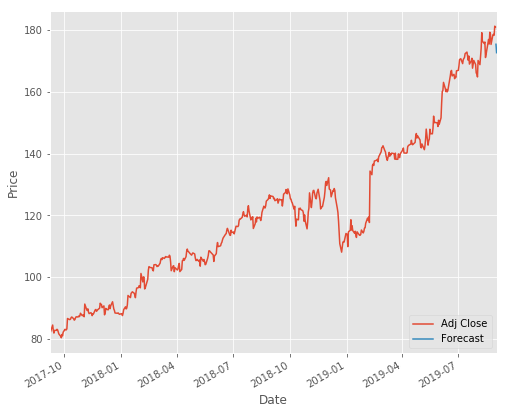

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

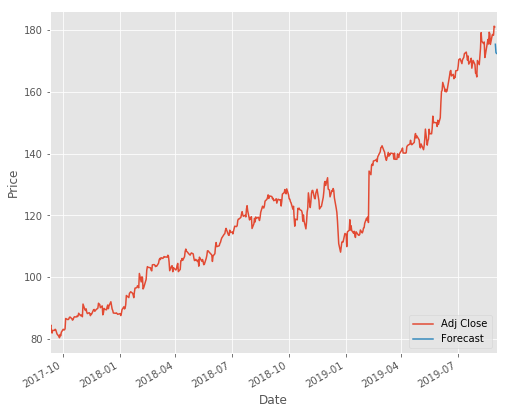

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

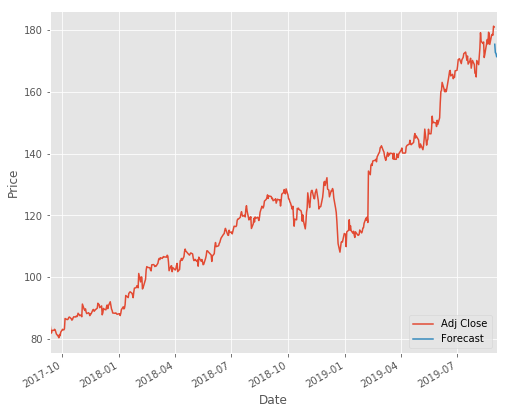

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

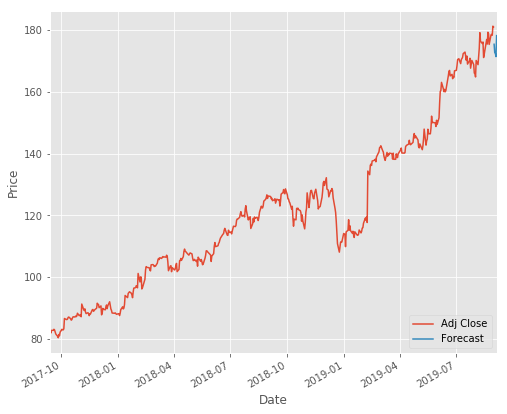

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

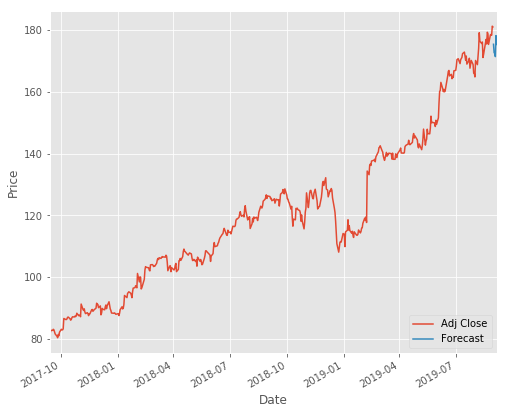

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

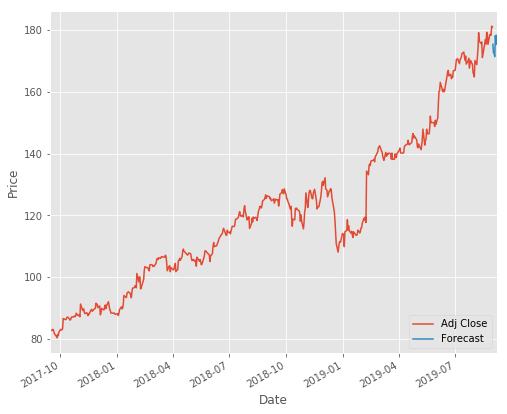

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

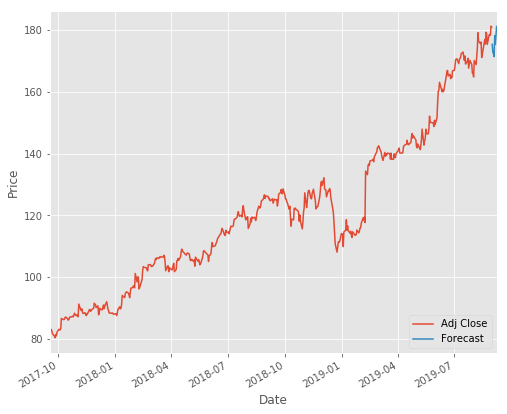

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

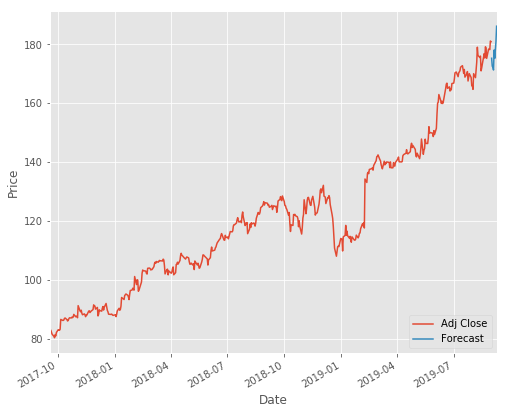

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

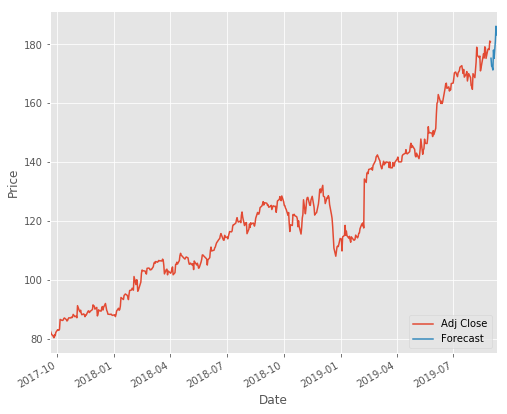

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

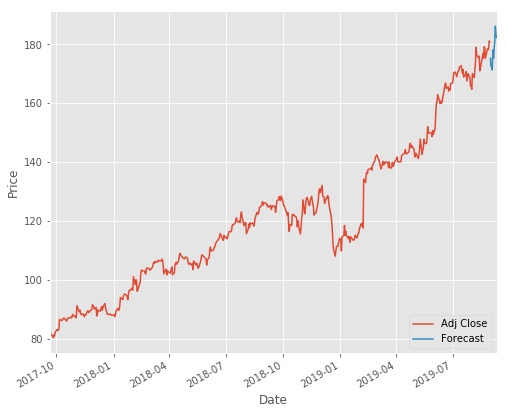

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

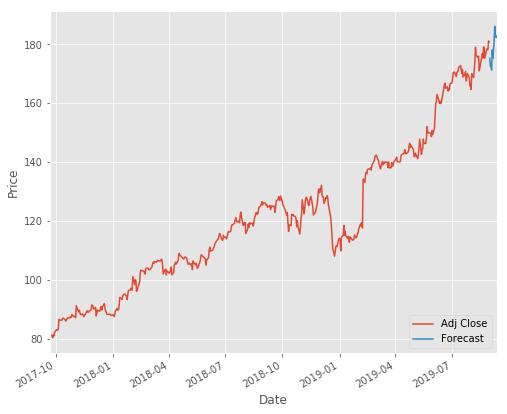

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

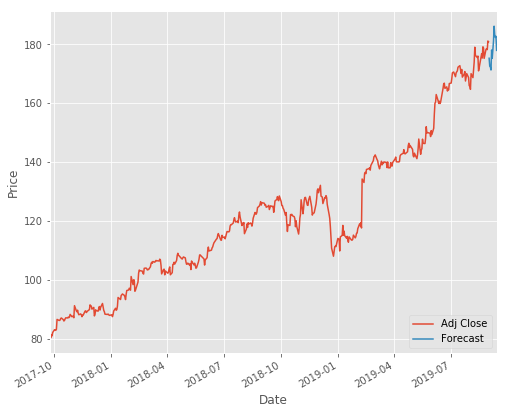

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

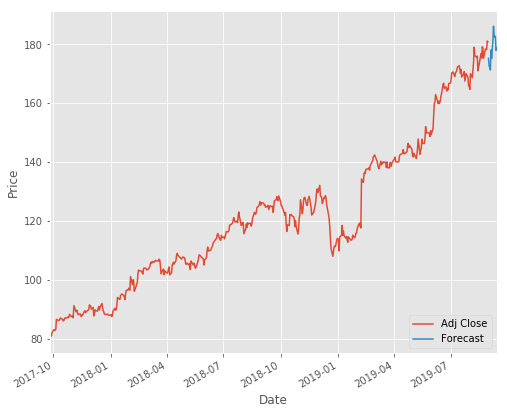

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

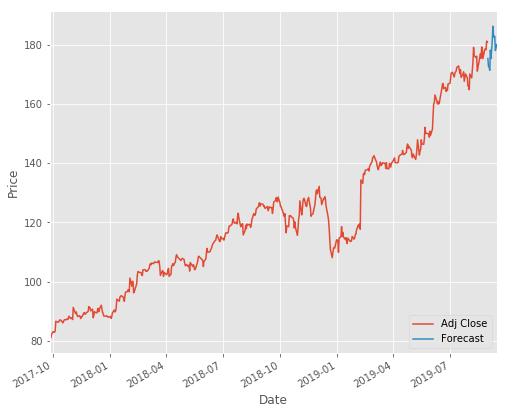

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

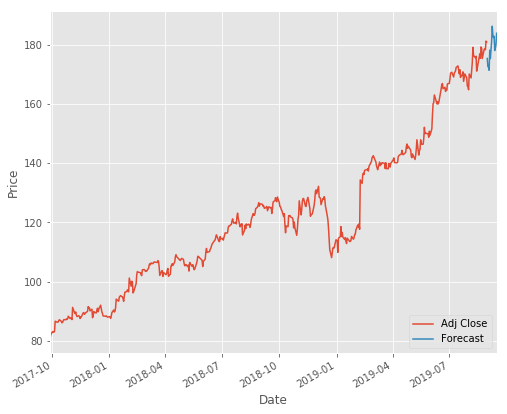

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

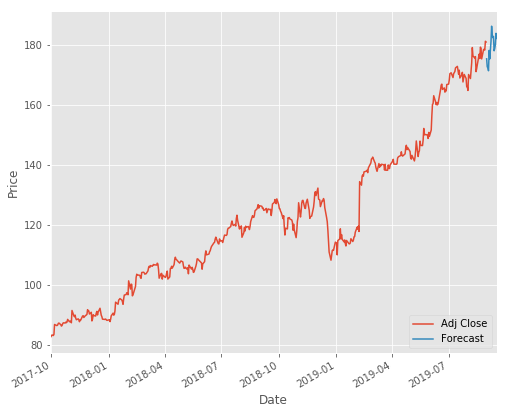

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

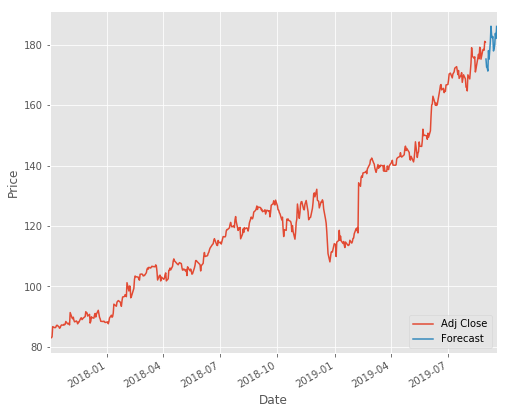

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

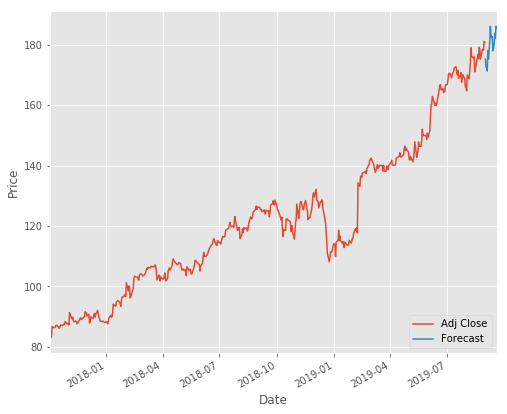

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

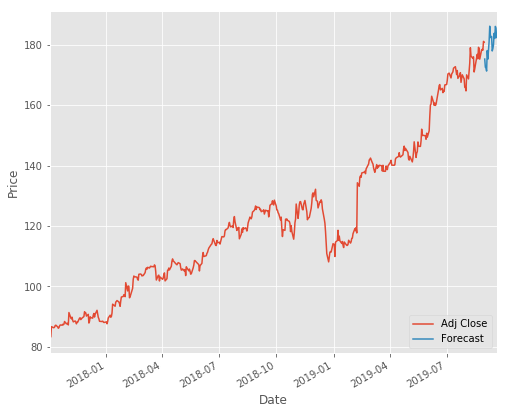

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

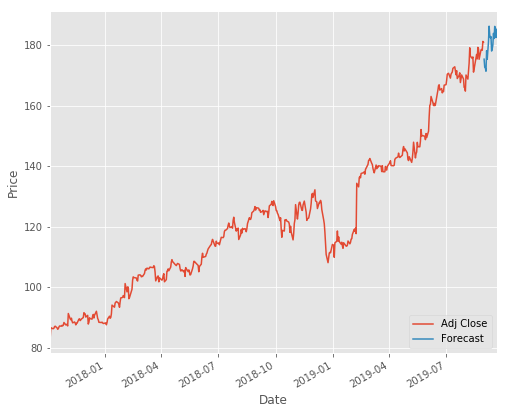

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

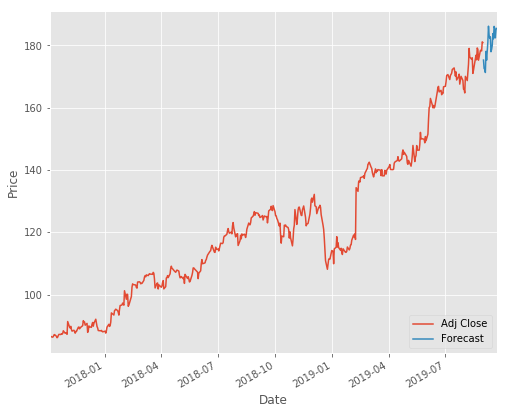

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

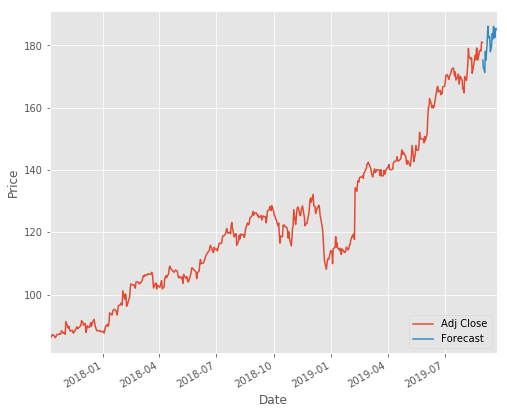

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

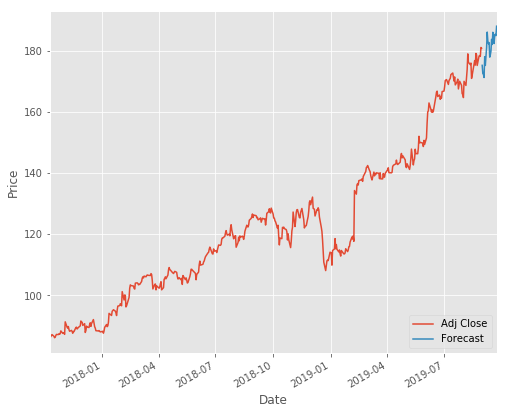

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

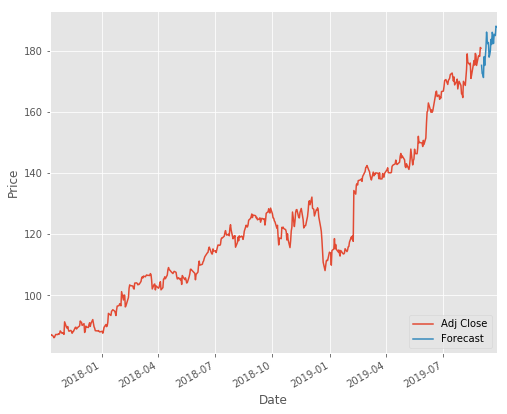

In [0]:
#results

#Plotting the forecast with existing historical data so we can compare it to future price movements
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_reg: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

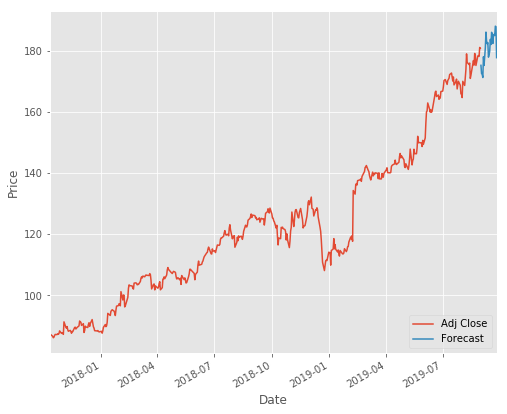

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

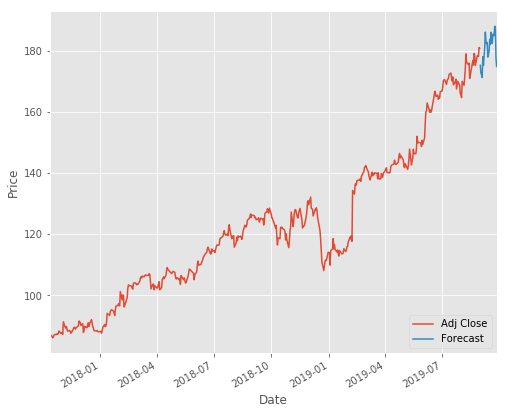

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

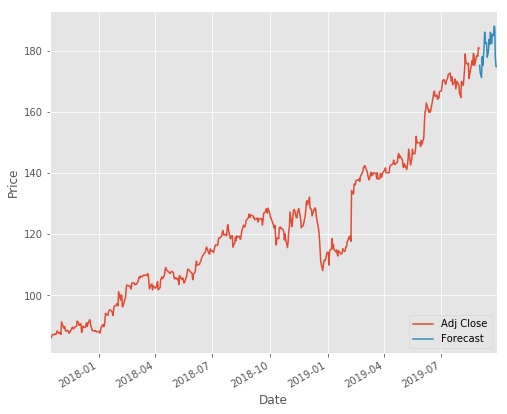

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

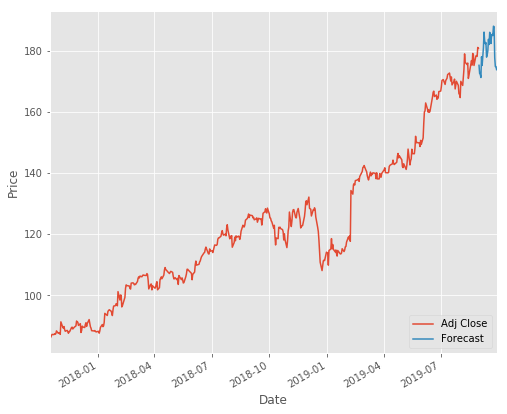

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

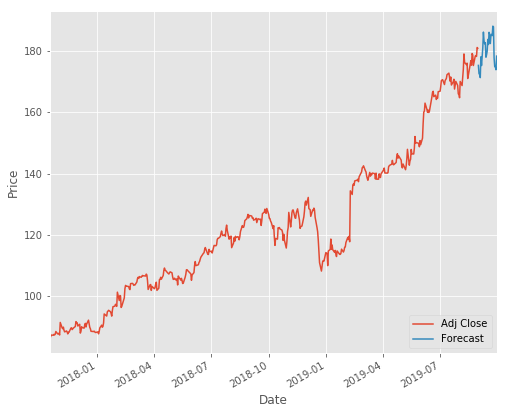

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

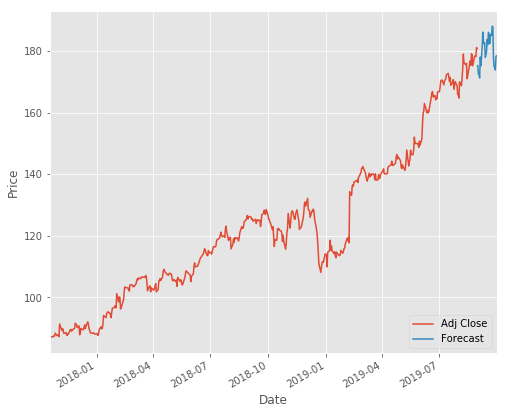

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

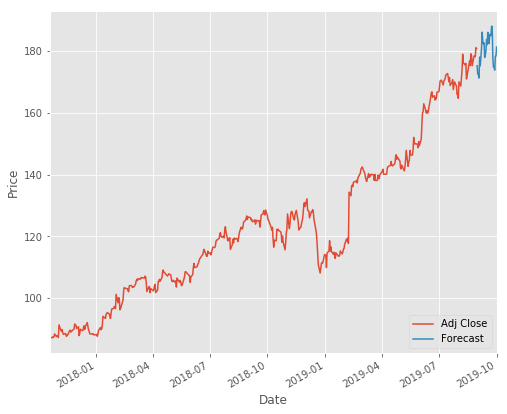

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

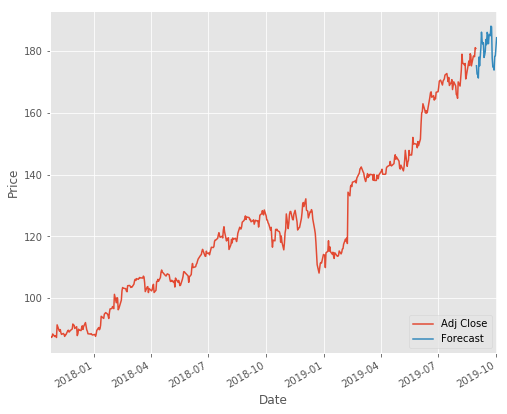

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

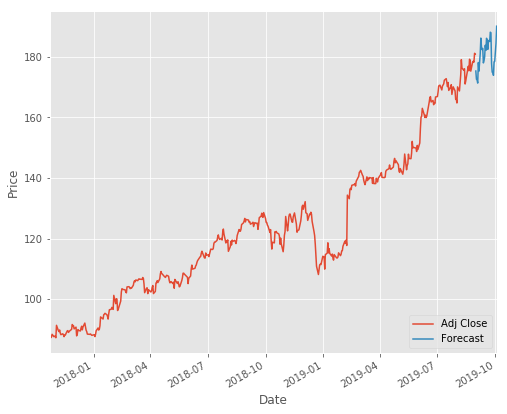

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

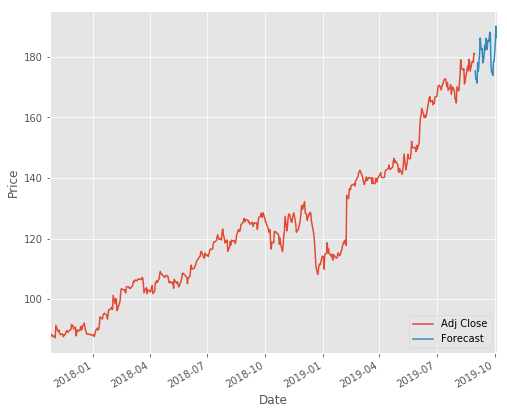

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

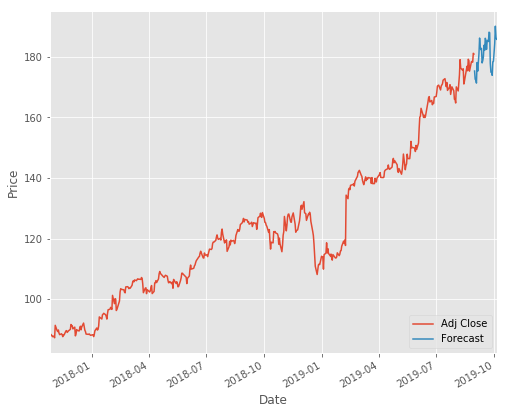

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

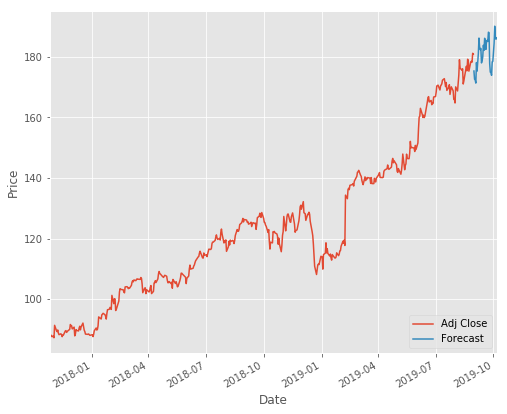

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

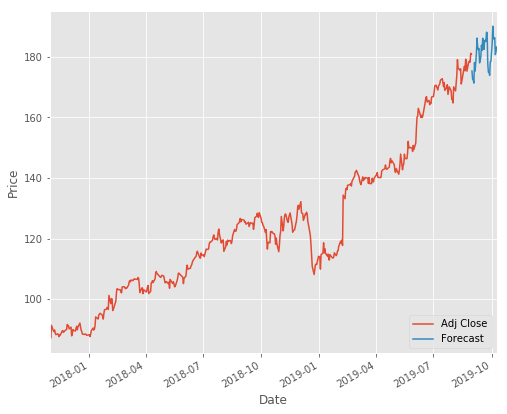

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

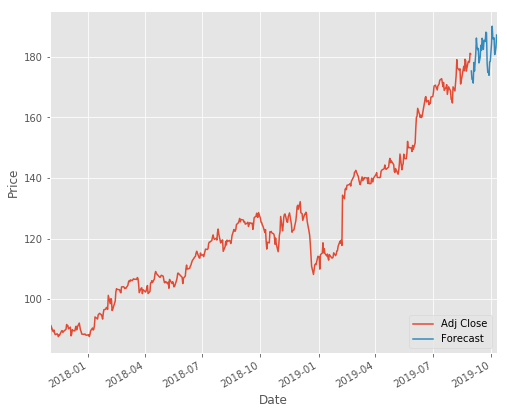

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

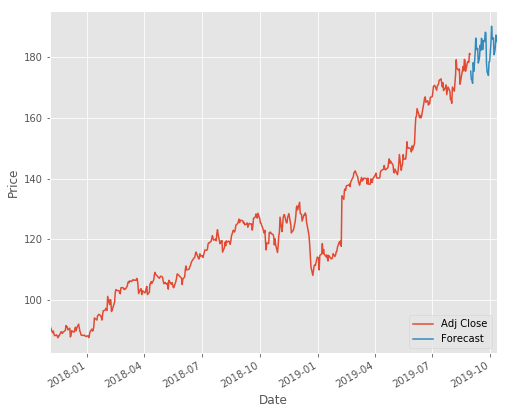

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

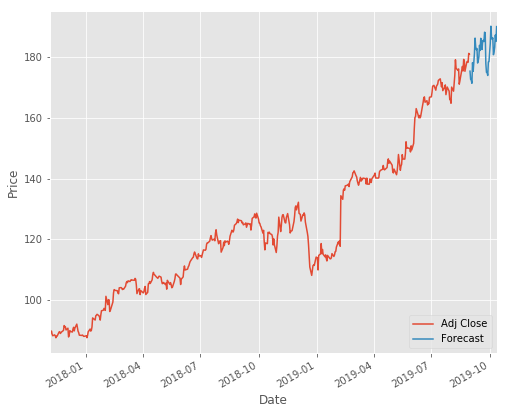

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

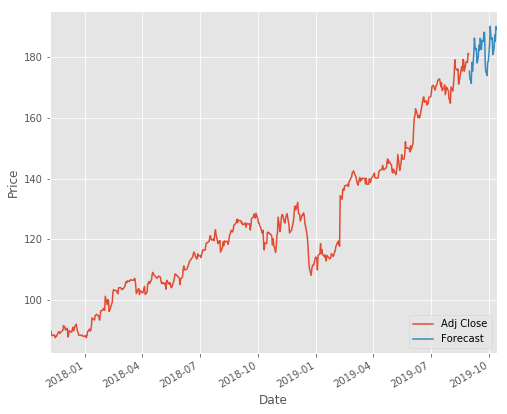

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

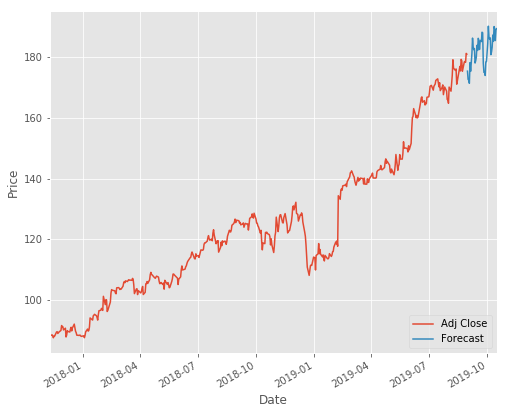

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

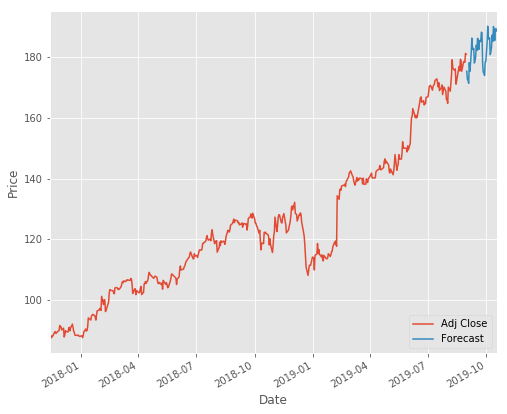

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

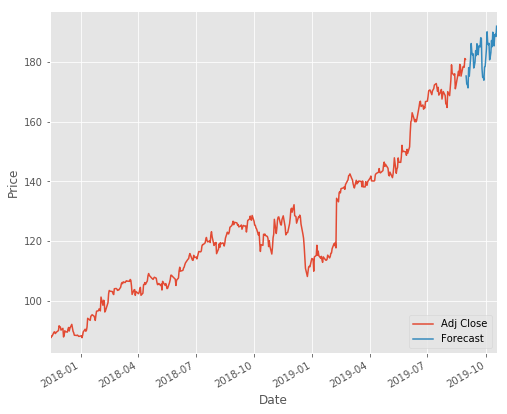

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

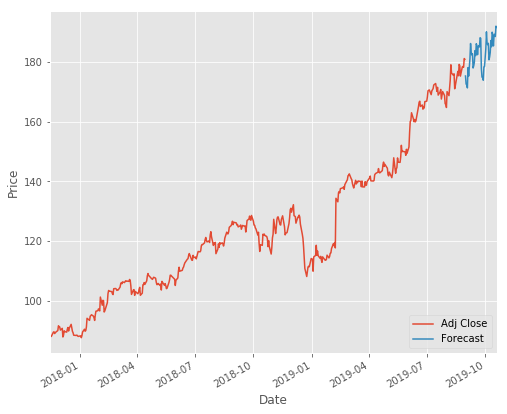

In [0]:
#@title
for i in forecast_set_poly2: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

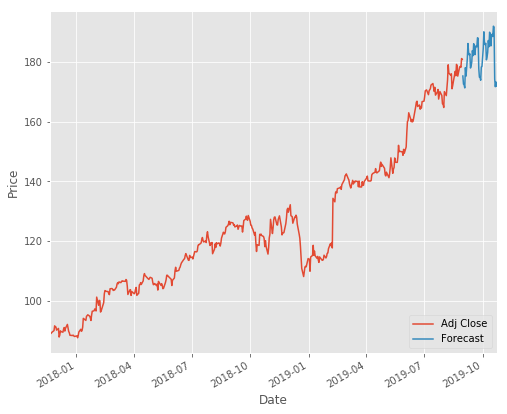

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

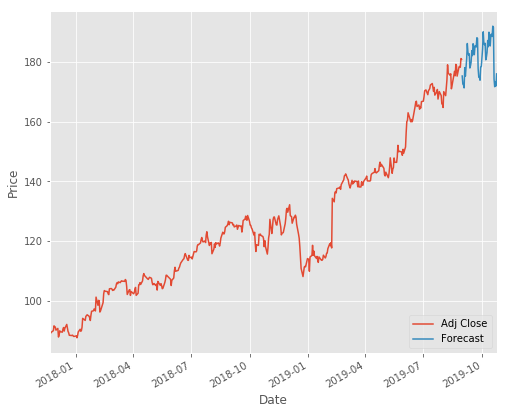

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

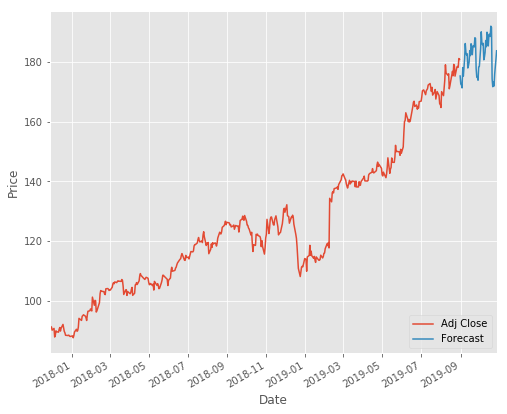

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

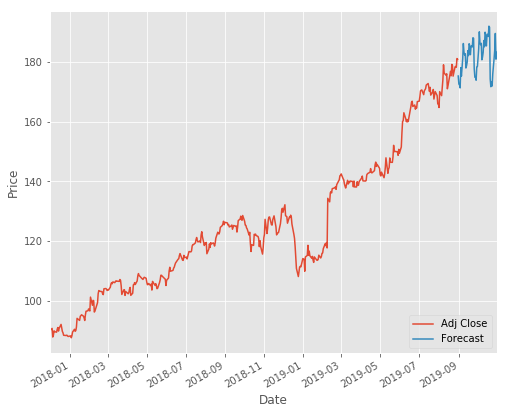

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

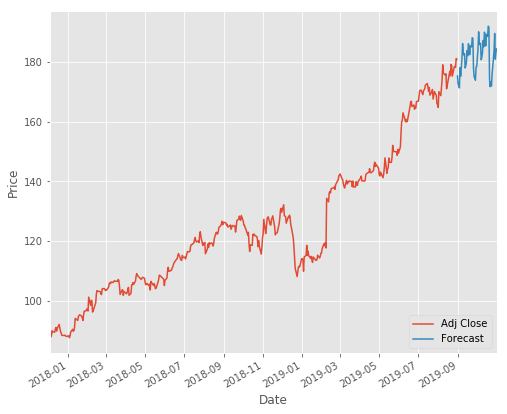

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

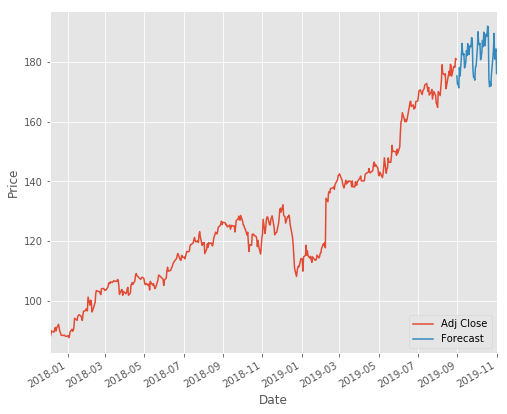

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

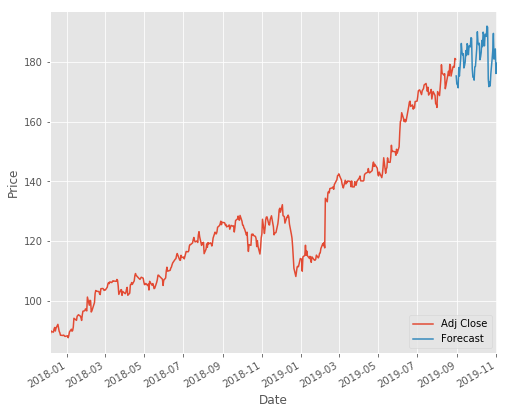

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

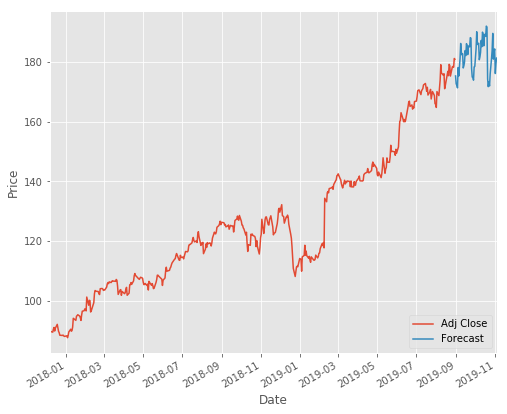

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

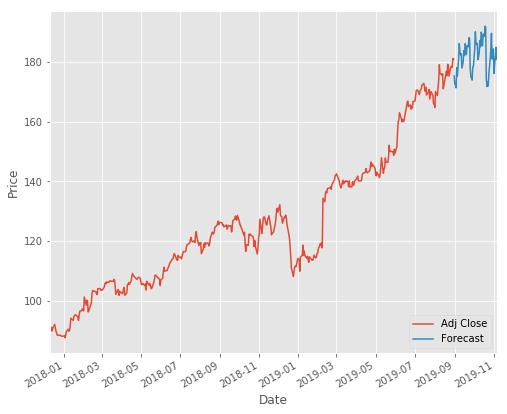

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

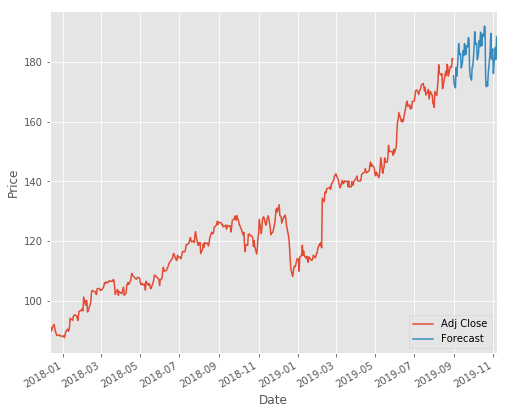

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

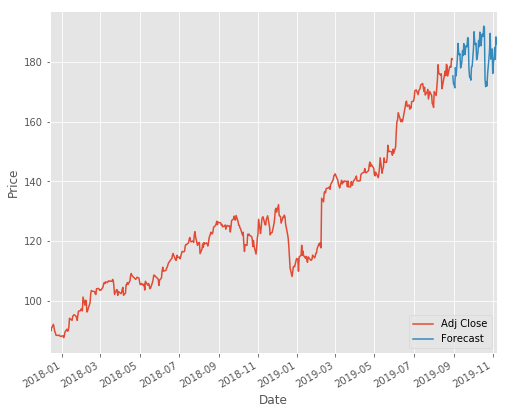

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

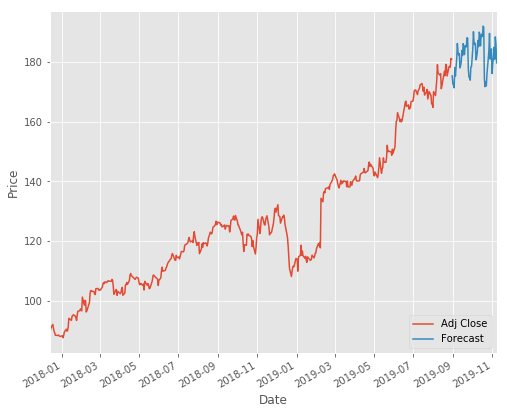

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

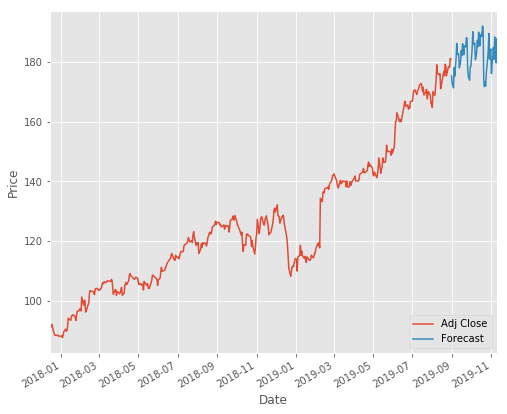

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

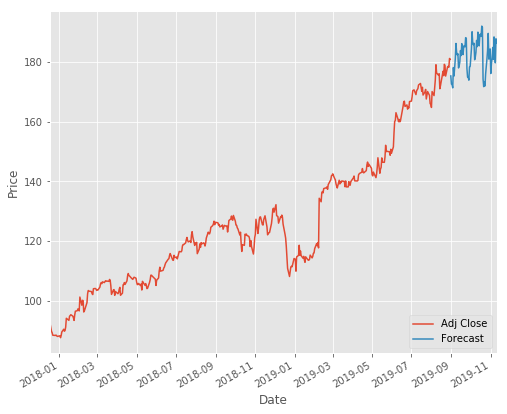

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

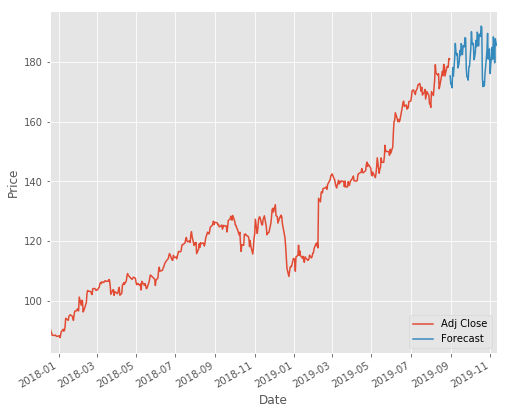

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

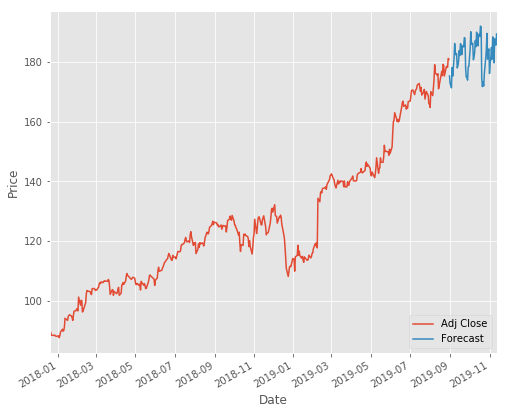

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

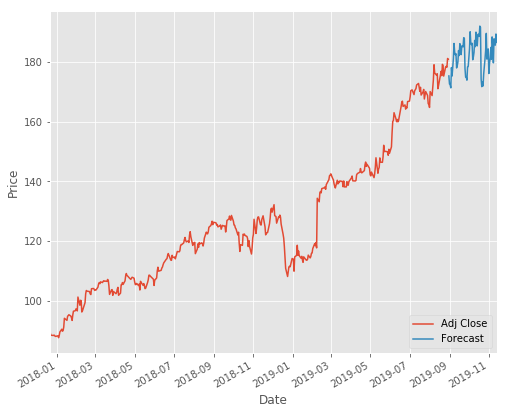

In [0]:
for i in forecast_set_poly3: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

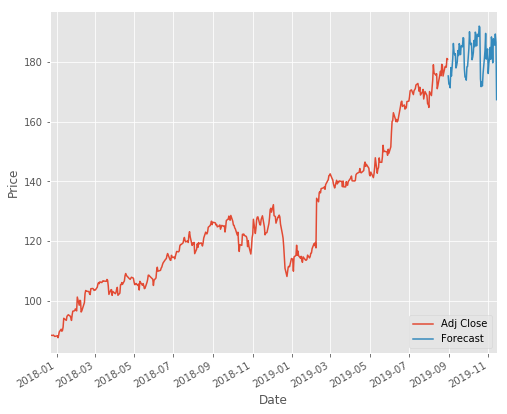

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

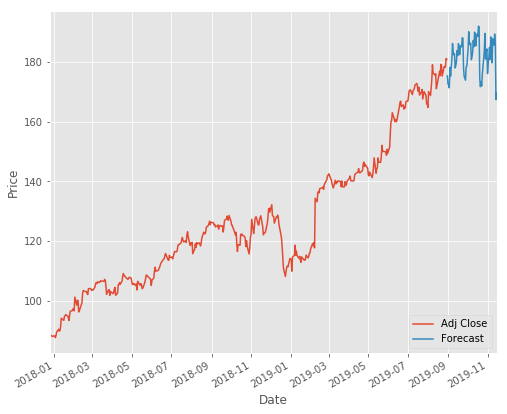

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

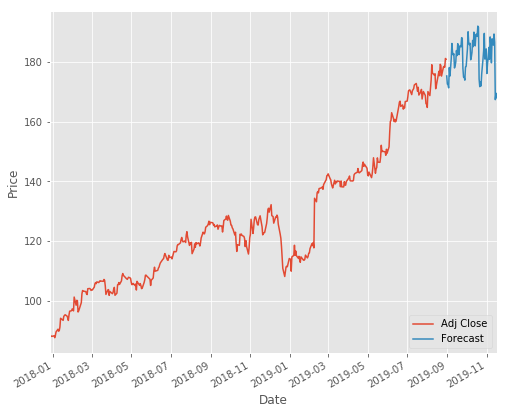

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

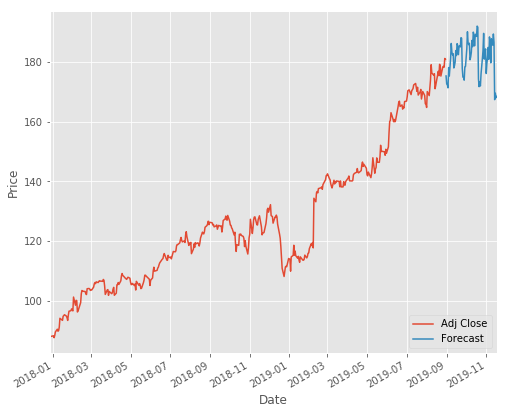

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

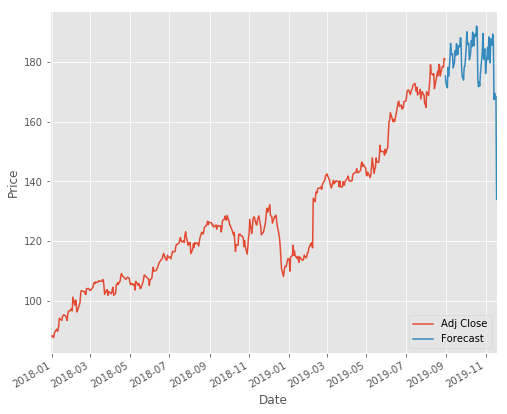

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

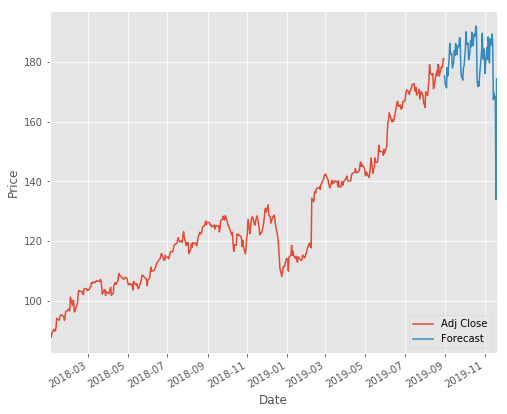

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

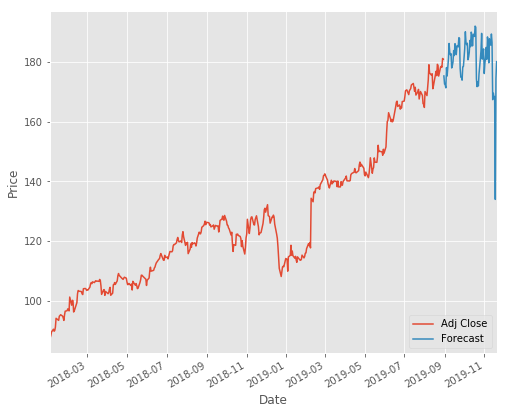

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

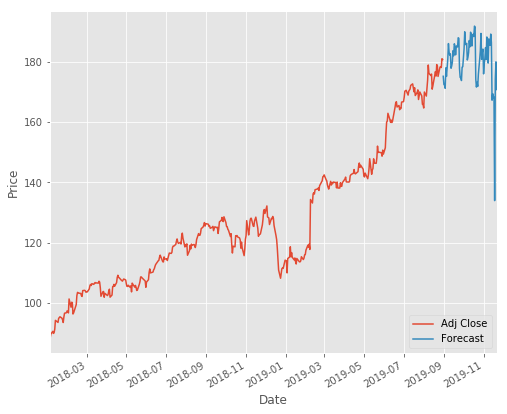

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

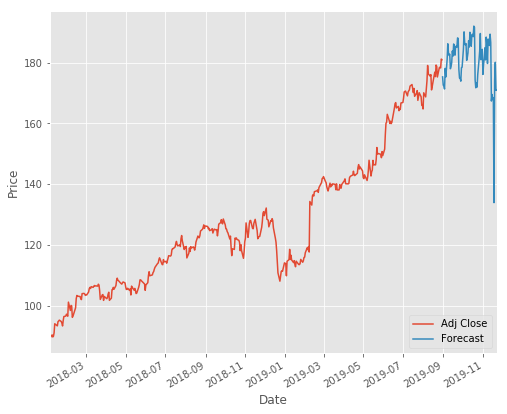

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

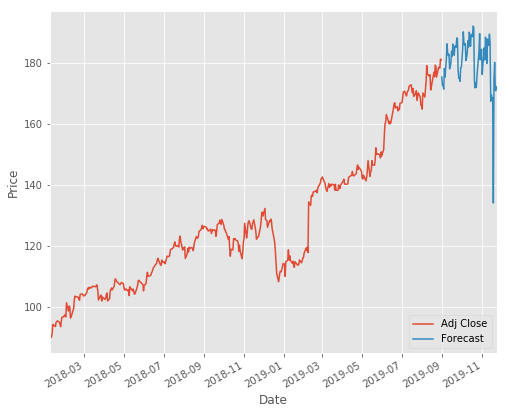

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

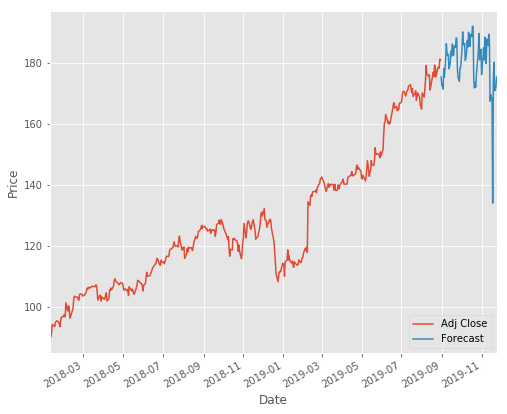

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

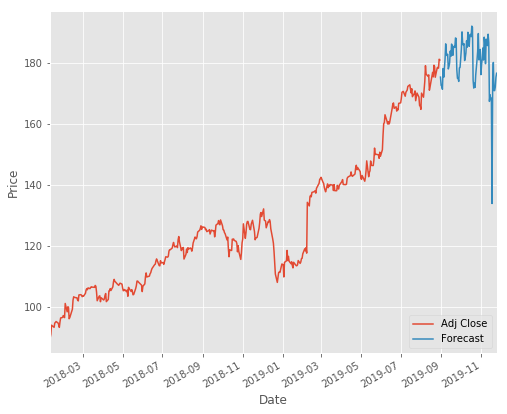

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

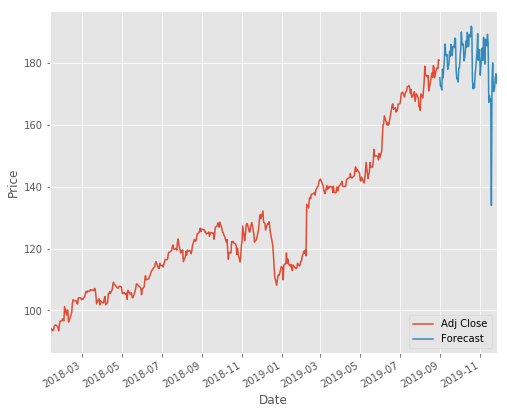

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

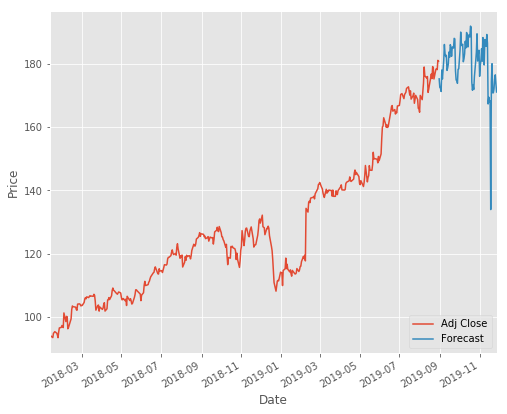

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

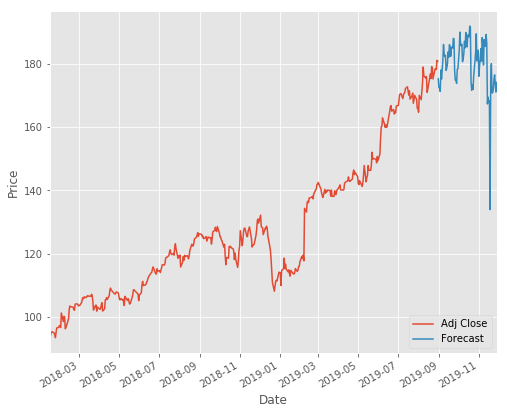

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

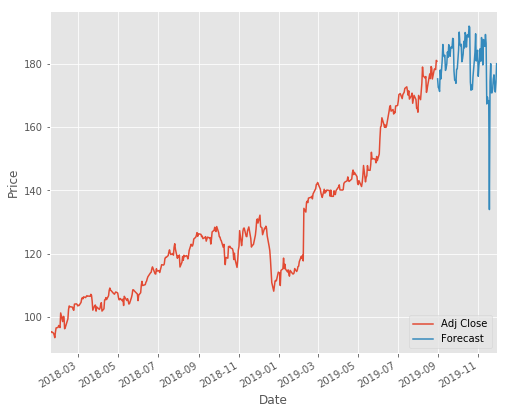

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

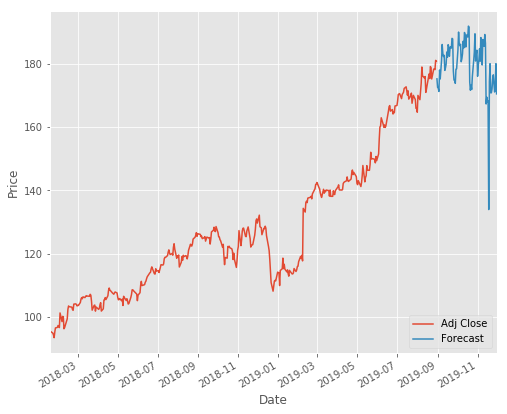

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

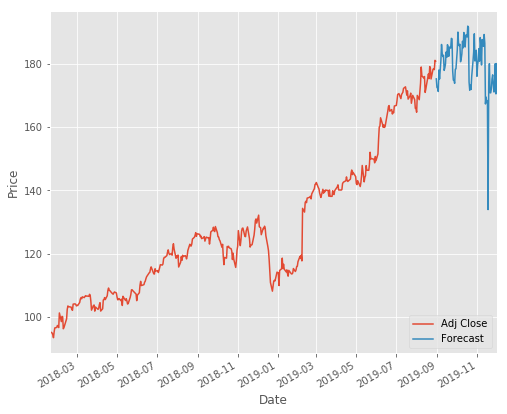

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

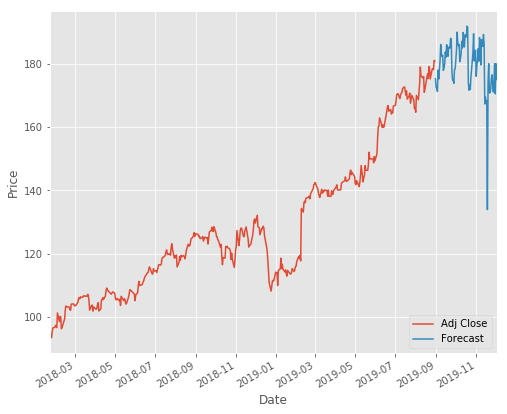

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

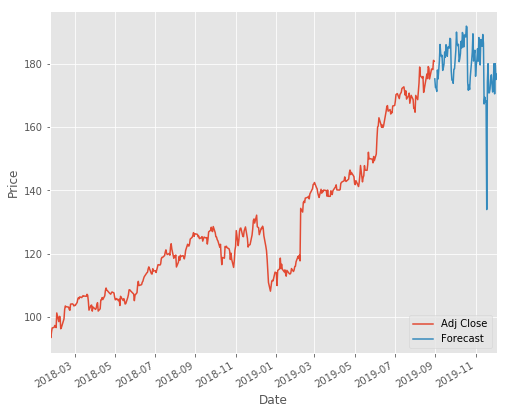

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

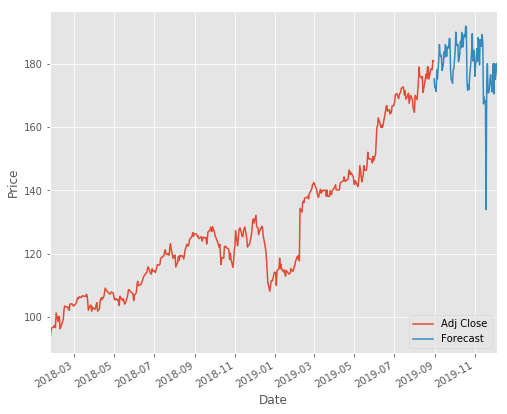

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

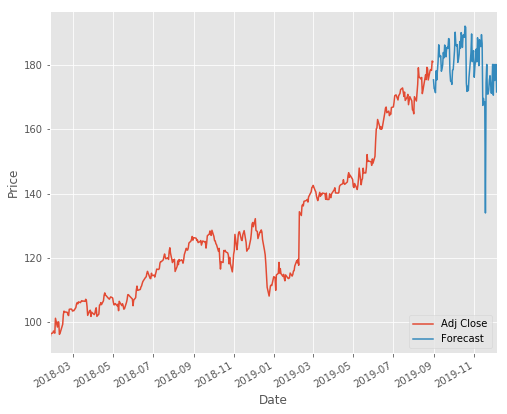

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

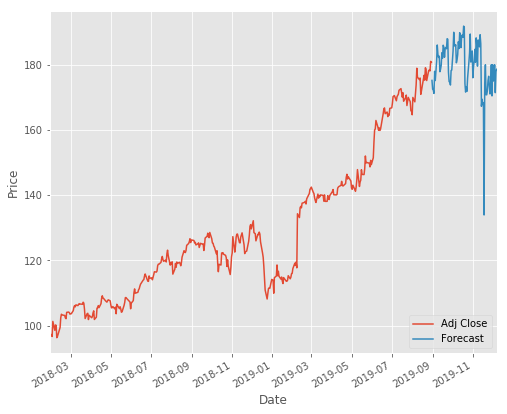

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

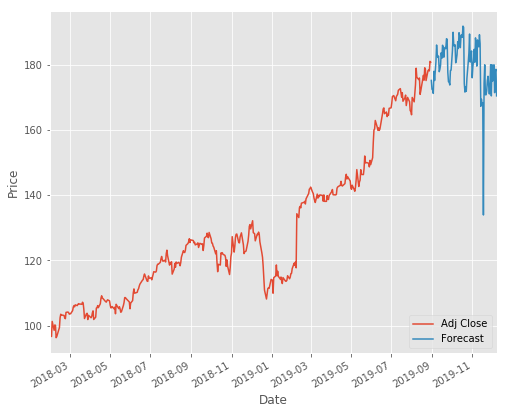

In [0]:
for i in forecast_set_knn: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

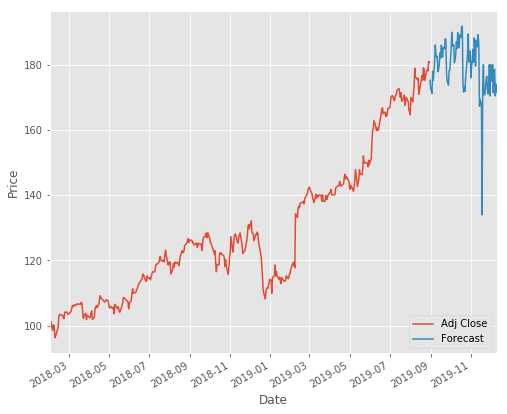

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

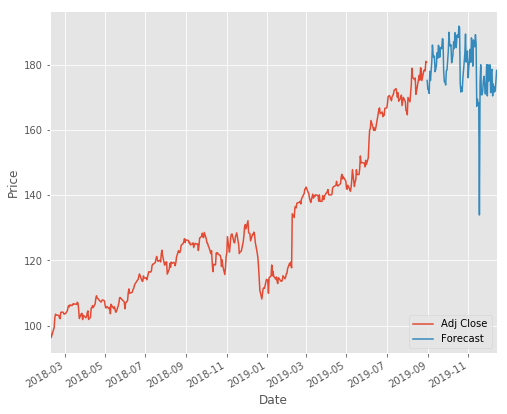

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

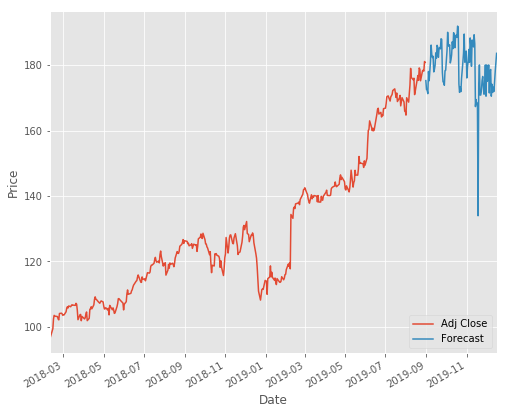

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

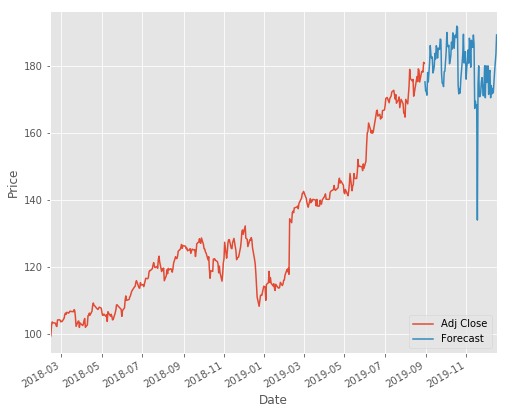

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

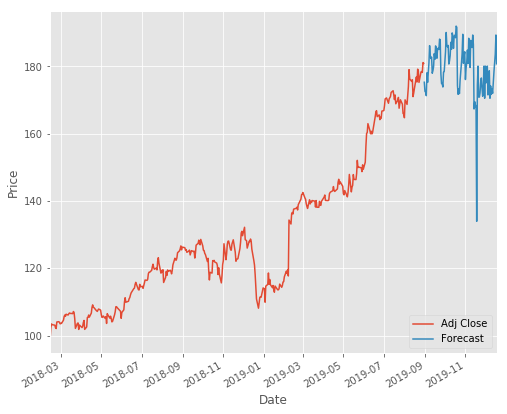

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

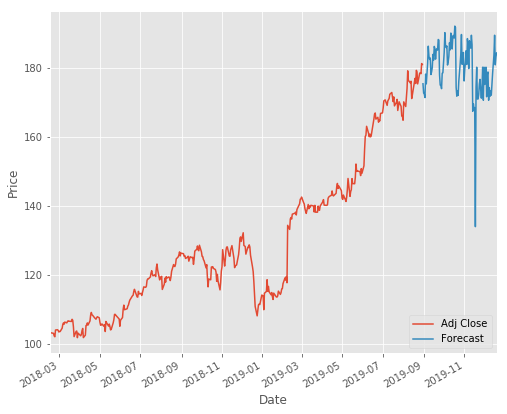

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

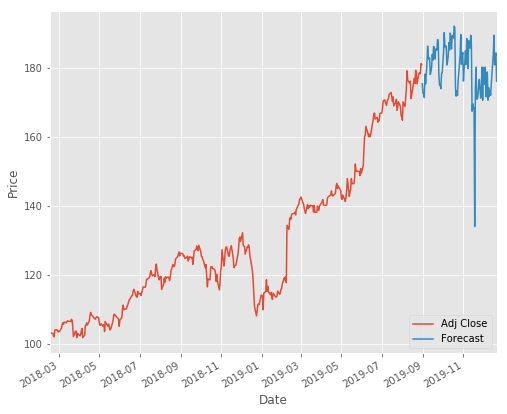

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

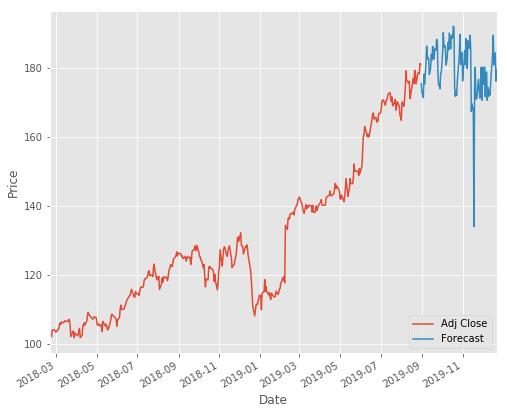

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

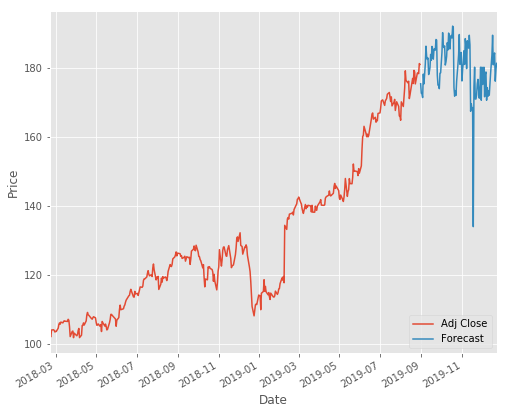

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

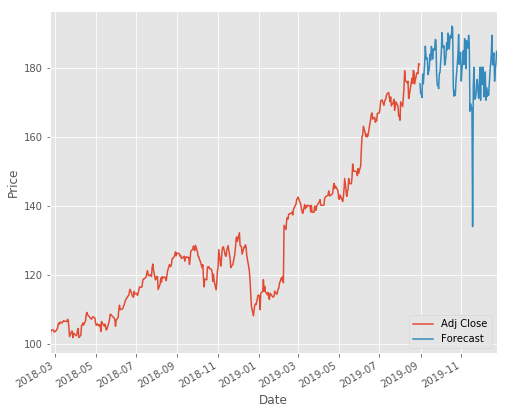

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

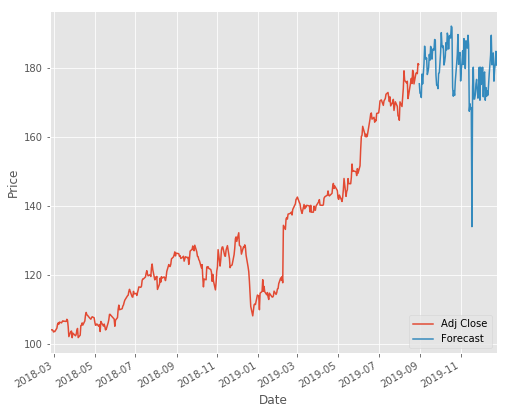

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

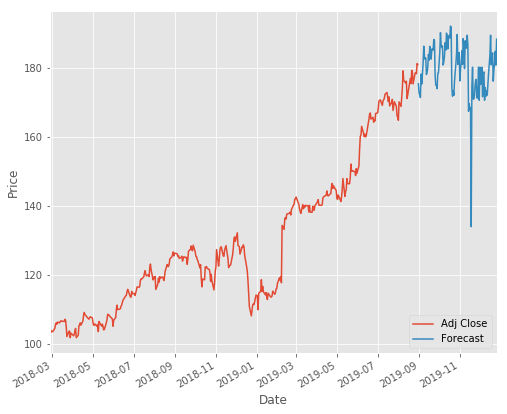

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

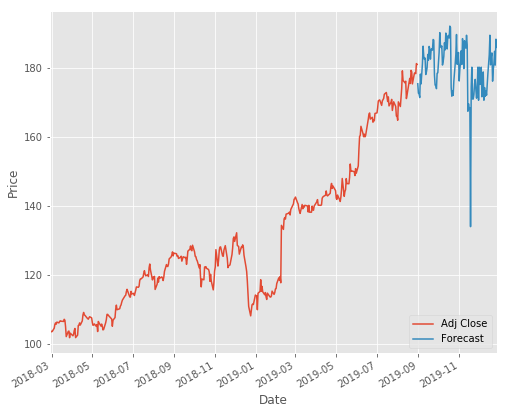

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

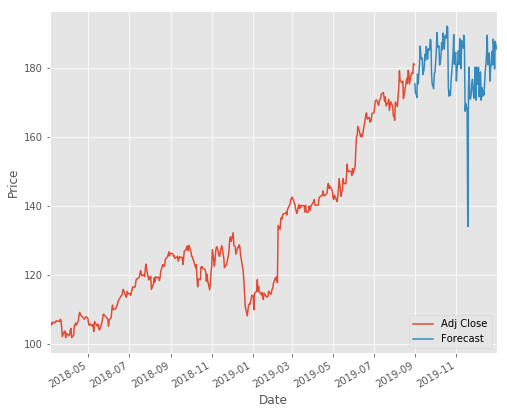

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

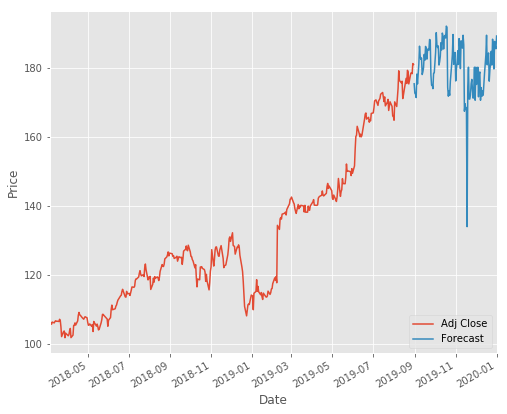

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

In [0]:
#@title
for i in forecast_set_polyb: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()